In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

This is a dataset from kaggle playground s5e7 and in this data sets we are going to predict introvert
and extrovert based on the number of different predictors.

In [48]:
train = pd.read_csv('D:/ML/Kaggle/playground-series-s5e7/train.csv')
test = pd.read_csv('D:/ML/Kaggle/playground-series-s5e7/test.csv')

In [3]:
## EDA 
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
len(train)

18524

In [ ]:
### Checking for the missing values, there are many NAs in the data set.
train.isna().sum()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


We need to deal with NA and sklearn does not accept object class

In [40]:
pipe_for_imputation = Pipeline([
    ("cat_imputer", CategoricalImputer(
        variables=['Stage_fear', 'Drained_after_socializing', 'Personality'],
        fill_value="missing")),
    ("num_imputer", MeanMedianImputer(
        imputation_method='median',
        variables=['Time_spent_Alone', 'Social_event_attendance', 
                   'Going_outside', 'Friends_circle_size', 'Post_frequency'])),
    ("encoder", OrdinalEncoder(encoding_method='arbitrary'))
])

In [41]:
pipe_for_imputation.fit(train)

Pipeline(steps=[('cat_imputer',
                 CategoricalImputer(fill_value='missing',
                                    variables=['Stage_fear',
                                               'Drained_after_socializing',
                                               'Personality'])),
                ('num_imputer',
                 MeanMedianImputer(variables=['Time_spent_Alone',
                                              'Social_event_attendance',
                                              'Going_outside',
                                              'Friends_circle_size',
                                              'Post_frequency'])),
                ('encoder', OrdinalEncoder(encoding_method='arbitrary'))])

In [49]:
train= pipe_for_imputation.fit_transform(train)

In [45]:
pipe_for_imputation_test = Pipeline([
    ("cat_imputer", CategoricalImputer(
        variables=['Stage_fear', 'Drained_after_socializing'],
        fill_value="missing")),
    ("num_imputer", MeanMedianImputer(
        imputation_method='median',
        variables=['Time_spent_Alone', 'Social_event_attendance', 
                   'Going_outside', 'Friends_circle_size', 'Post_frequency'])),
    ("encoder", OrdinalEncoder(encoding_method='arbitrary'))
])

In [50]:
test= pipe_for_imputation_test.fit_transform(test)

<Axes: >

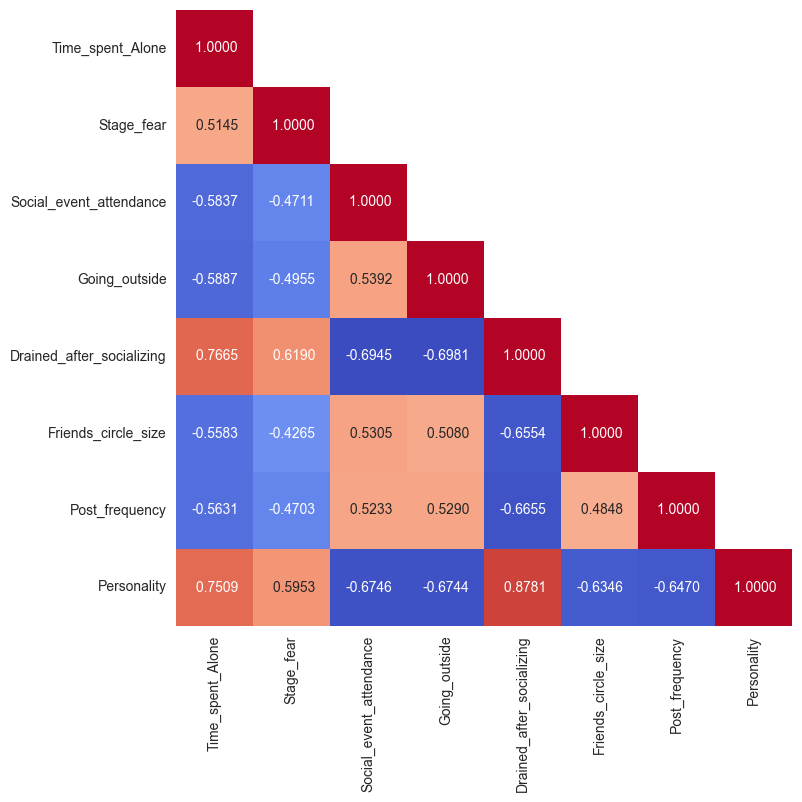

In [57]:
sns.set_style('white')
plt.figure(figsize=(8,8))
train_corr = train.drop('id', axis =1).corr()
mask_train = np.triu(np.ones_like(train_corr, dtype=bool), k=1)
sns.heatmap(
    data=train_corr,
    mask = mask_train, 
    annot=True, 
    fmt = ' .4f', 
    square = True, 
    cmap = 'coolwarm',
    cbar = False
)

In [58]:
X = train.drop(['id', 'Personality'], axis =1)
y = train['Personality']
X_train, X_valid, y_train, y_valid =  train_test_split(
    X, 
    y, 
    test_size = .2, 
    random_state = 123)

I will use Extreme Gradient Boosting

In [88]:
model_xgb = XGBClassifier(
    n_estimators=750,
    learning_rate=0.025,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=123, 
    use_label_encoder = False,
)


In [90]:
model_xgb.fit(
    X_train, 
    y_train,
)

D:\anaconda\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:42:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.025, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=750,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [92]:
y_pred = model_xgb.predict(X_valid)

In [97]:
y_pred_proba = model_xgb.predict_proba(X_valid)[:,1]

In [93]:
accuracy_score(y_valid, y_pred)

0.9692307692307692

In [95]:
cm = confusion_matrix(y_valid, y_pred)
print("Confusion_Matrix:")
print(cm)

Confusion_Matrix:
[[2698   53]
 [  61  893]]


In [96]:
print("Classification Report:")
print(classification_report(y_valid, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2751
           1       0.94      0.94      0.94       954

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



In [98]:
auc = roc_auc_score(y_valid, y_pred_proba)
print(f"ROC-AUC: {auc:.4f}")

ROC-AUC: 0.9696


In [102]:
X_test = test.drop(columns  = 'id')
predict_test = model_xgb.predict(X_test)

In [103]:
submission = test[['id']].copy()
submission['prediction'] = predict_test

In [104]:
submission.to_csv("submission_xgboost.csv", index=False)